In [0]:
! pip install git+https://github.com/fastai/fastai_dev

In [0]:
from fastai import * 
from fastai.text import * 

In [0]:
from fastai.callbacks import * 

In [0]:
from fastai.text import *

In [0]:
from fastai.callbacks import Hooks

In [0]:
import os 

In [0]:
import warnings

In [0]:
warnings.filterwarnings("ignore")


In [0]:
bs=48
path = untar_data(URLs.IMDB)
path.ls()





[PosixPath('/root/.fastai/data/imdb/unsup'),
 PosixPath('/root/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/root/.fastai/data/imdb/test'),
 PosixPath('/root/.fastai/data/imdb/tmp_clas'),
 PosixPath('/root/.fastai/data/imdb/train'),
 PosixPath('/root/.fastai/data/imdb/README'),
 PosixPath('/root/.fastai/data/imdb/tmp_lm')]

In [0]:
path

PosixPath('/root/.fastai/data/imdb')

In [0]:

data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

In [0]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)


In [0]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)


In [0]:
learn_lm.save_encoder('fine_tuned_enc')


In [0]:
learn_lm.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(60000, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60000, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60000, bias=True)
    (output_dp): RNNDropout()
  )
)

In [0]:

data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [0]:
from fastai.callbacks import HookCallback
from torch.nn import LSTM

In [0]:
class  Hook():
    "Create a hook on `m` with `hook_func`."
    def __init__(self, m:nn.Module, hook_func:HookFunc, is_forward:bool=True, detach:bool=True):
        self.hook_func,self.detach,self.stored = hook_func,detach,None
        f = m.register_forward_hook if is_forward else m.register_backward_hook
        self.hook = f(self.hook_fn)
        self.removed = False

    def hook_fn(self, module:nn.Module, input:Tensors, output:Tensors):
        "Applies `hook_func` to `module`, `input`, `output`."
        if self.detach:
            input  = (o.detach() for o in input ) if is_listy(input ) else input.detach()
            output = (o.detach() for o in output) if is_listy(output) else output.detach()
        self.stored = self.hook_func(module, input, output)

    def remove(self):
        "Remove the hook from the model."
        if not self.removed:
            self.hook.remove()
            self.removed=True

    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()

class Hooks():
    "Create several hooks on the modules in `ms` with `hook_func`."
    def __init__(self, ms:Collection[nn.Module], hook_func:HookFunc, is_forward:bool=True, detach:bool=True):
        self.hooks = [Hook(m, hook_func, is_forward, detach) for m in ms]

    def __getitem__(self,i:int)->Hook: return self.hooks[i]
    def __len__(self)->int: return len(self.hooks)
    def __iter__(self): return iter(self.hooks)
    @property
    def stored(self): return [o.stored for o in self]

    def remove(self):
        "Remove the hooks from the model."
        for h in self.hooks: h.remove()

    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()


In [0]:
class Hook():
    "Create a hook on `m` with `hook_func`."
    def __init__(self, m, hook_func, is_forward=True, detach=True):
        self.hook_func,self.detach,self.stored = hook_func,detach,None
        f = m.register_forward_hook if is_forward else m.register_backward_hook
        self.hook = f(self.hook_fn)
        self.removed = False

    def hook_fn(self, module, input, output):
        "Applies `hook_func` to `module`, `input`, `output`."
        import pdb;pdb.set_trace()
        if self.detach:
            input  = (o.detach() for o in input ) if is_listy(input ) else input.detach()
            output = (o.detach() for o in output) if is_listy(output) else output.detach()

        self.stored = self.hook_func(module, input, output)

    def remove(self):
        "Remove the hook from the model."
        if not self.removed:
            self.hook.remove()
            self.removed=True

    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()


class Hooks():
    "Create several hooks on the modules in `ms` with `hook_func`."
    def __init__(self, ms, hook_func, is_forward=True, detach=True):
        self.hooks = [Hook(m, hook_func, is_forward, detach) for m in ms]

    def __getitem__(self,i:int)->Hook: return self.hooks[i]
    def __len__(self)->int: return len(self.hooks)
    def __iter__(self): return iter(self.hooks)
    @property
    def stored(self): return [o.stored for o in self]

    def remove(self):
        "Remove the hooks from the model."
        for h in self.hooks: h.remove()

    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()


In [0]:
class HookCallback(LearnerCallback):
    "Callback that can be used to register hooks on `modules`. Implement the corresponding function in `self.hook`."
    def __init__(self, learn:Learner, modules:Sequence[nn.Module]=None, do_remove:bool=True):
        super().__init__(learn)
        self.modules,self.do_remove = modules,do_remove

    def on_train_begin(self, **kwargs):
        "Register the `Hooks` on `self.modules`."
        if not self.modules:
            self.modules = [m for m in flatten_model(self.learn.model)
                            if isinstance(m, torch.nn.LSTM)]
        self.hooks = Hooks(self.modules, self.hook)

    def on_train_end(self, **kwargs):
        "Remove the `Hooks`."
        if self.do_remove: self.remove()

    def remove(self): 
        if getattr(self, 'hooks', None): self.hooks.remove()
    def __del__(self): self.remove()


class ActivationStats_LSTM(HookCallback):
    "Callback that record the mean and std of activations."

    def on_train_begin(self, **kwargs):
        "Initialize stats."
        super().on_train_begin(**kwargs)
        self.stats = []

    def hook(self, m, i, o):
        "Take the mean and std of `o`."
        import pdb;pdb.set_trace()
        return o[1][0].mean().item(),o[1][0].std().item()
    def on_batch_end(self, train, **kwargs):
        "Take the stored results and puts it in `self.stats`"
        if train: self.stats.append(self.hooks.stored)
    def on_train_end(self, **kwargs):
        "Polish the final result."
        super().on_train_end(**kwargs)
        self.stats = tensor(self.stats).permute(2,1,0)

class LSUV_HookCallBack(HookCallback):

    def on_train_begin(self, **kwargs):
        "Register the `Hooks` on `self.modules`."

        super().on_train_begin(**kwargs)
        self.xb, self.yb = self.learn.data.one_batch()
        self.xb = self.xb.cuda()


        self.stats = {}

        for idx,(mod,hook) in enumerate(zip(self.modules, self.hooks)):
          self.stats[idx] = []
          _ = self.learn.model(self.xb)
          self.stats[idx].append(hook.stored[1])
          print(idx)
          print(hook.stored[1])
          
          while self.learn.model(self.xb) is not None and abs(hook.stored[1]-1) > 1e-3:
            mod.weight.data /= hook.stored[1]
            _ = self.learn.model(self.xb)
            print(hook.stored[1])
            self.stats[idx].append(hook.stored[1])

            
      
    def hook(self, m:nn.Module, i:tuple, o:tuple)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return o.mean().item(),o.std().item()

In [0]:
gc.collect()

0

In [0]:
# Without ActivationStats

learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
# learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5,callback_fns=ActivationStats_LSTM)



In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


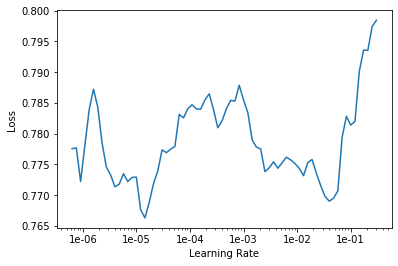

In [0]:
learn.recorder.plot(skip_end=15)


In [0]:
learn.fit_one_cycle(1, 5e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.695164,0.688270,0.500000,09:59


In [0]:
from fastai.callbacks import ActivationStats

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5,callback_fns=ActivationStats)
learn.fit_one_cycle(1, 5e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.693610,0.678808,0.527320,10:53


RuntimeError: ignored